# __FINAL PROJECT PHASE II__

# __RESEARCH QUESTION:__
Can we predict presence and rank of of the song on Spotify charts of different artists based on factors like danceability, valence, and energy?

### Importing:

In [1]:
# imports and settings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import duckdb
import seaborn as sns

## Data Description:
Source: https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/data 

We are using a dataset that contains detailed information on the most famous songs of 2023, specifically focusing on their performance on major music platforms like Spotify, Apple Music, Deezer, and Shazam. It includes key metadata such as the song's name, artist(s), and release date, along with streaming data, playlist presence, and chart rankings across platforms. Additionally, the dataset offers a range of audio features, including tempo (BPM), key, mode (major/minor), and percentages indicating danceability, energy, acousticness, and other sonic characteristics, providing a comprehensive view of each track's musical and commercial success.



In [47]:
music_df = pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')
print(music_df.shape)
music_df.head()

(953, 24)


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [66]:
#To first get an idea of the summary of the data
music_df.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.00000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,1.556139,2018.238195,6.033578,13.930745,5200.124869,12.009444,67.812172,51.908709,2.666317,122.540399,66.96957,51.431270,64.279119,27.057712,1.581322,18.213012,10.131165
std,0.893044,11.116218,3.566435,9.201949,7897.608990,19.575992,86.441493,50.630241,6.035599,28.057802,14.63061,23.480632,16.550526,25.996077,8.409800,13.711223,9.912888
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.00000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,875.000000,0.000000,13.000000,7.000000,0.000000,100.000000,57.00000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,2224.000000,3.000000,34.000000,38.000000,0.000000,121.000000,69.00000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,88.000000,87.000000,2.000000,140.000000,78.00000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,672.000000,275.000000,58.000000,206.000000,96.00000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


In [67]:
#Distribution of release years
years_count = music_df['released_year'].value_counts()
print(years_count.head()) 

released_year
2022    402
2023    175
2021    119
2020     37
2019     36
Name: count, dtype: int64


In [69]:
#Top artists by track count:
top_artists = music_df['artist(s)_name'].value_counts().head(10)
print(top_artists)

artist(s)_name
Taylor Swift      34
The Weeknd        22
Bad Bunny         19
SZA               19
Harry Styles      17
Kendrick Lamar    12
Morgan Wallen     11
Ed Sheeran         9
BTS                8
Feid               8
Name: count, dtype: int64


In [46]:
music_df = music_df.rename(columns={
    "artist(s)_name": "artist_name", 
    "danceability_%": "danceability", 
    "valence_%": "valence", 
    "energy_%": "energy"
})

music_df_result = duckdb.sql("""
    SELECT 
        artist_name AS Artist, 
        AVG(in_spotify_charts) AS Spotify_Rank, 
        AVG(danceability) AS Danceability, 
        AVG(valence) AS Valence, 
        AVG(energy) AS Energy 
    FROM music_df 
    GROUP BY artist_name
""").df()

music_df_result

,Artist,Spotify_Rank,Danceability,Valence,Energy
0,Olivia Rodrigo,18.571429,51.285714,38.428571,50.571429
1,NewJeans,28.000000,76.666667,57.500000,75.666667
2,"Bizarrap, Peso Pluma",40.000000,85.000000,81.000000,67.000000
3,"The Weeknd, Madonna, Playboi Carti",87.000000,85.000000,83.000000,68.000000
4,"Junior H, Peso Pluma",18.000000,65.500000,81.500000,64.000000
...,...,...,...,...,...
640,"Luis R Conriquez, La Adictiva",9.000000,70.000000,97.000000,59.000000
641,"Elton John, Britney Spears",0.000000,67.000000,49.000000,77.000000
642,Armani White,0.000000,90.000000,75.000000,50.000000
643,"Ludwig Goransson, Foudeqush",0.000000,62.000000,25.000000,44.000000


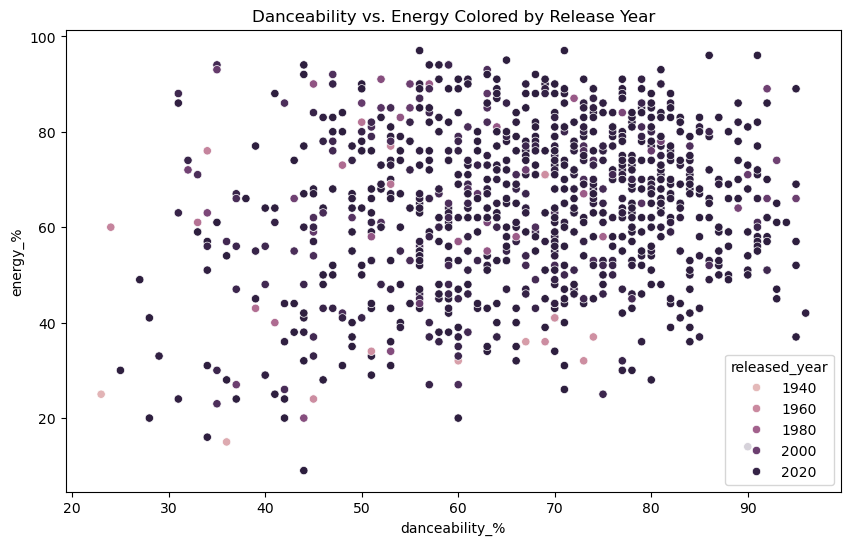

In [65]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='danceability_%', y='energy_%', data=music_df, hue='released_year')
plt.title('Danceability vs. Energy Colored by Release Year')
plt.show()

In [61]:
features = ['danceability_%', 'valence_%', 'energy_%', 'in_spotify_charts']
corr = music_df[features].corr()
corr

,danceability_%,valence_%,energy_%,in_spotify_charts
danceability_%,1.000000,0.408451,0.198095,0.030071
valence_%,0.408451,1.000000,0.357612,0.035531
energy_%,0.198095,0.357612,1.000000,0.081920
in_spotify_charts,0.030071,0.035531,0.081920,1.000000


<Axes: xlabel='Danceability', ylabel='Spotify_Rank'>

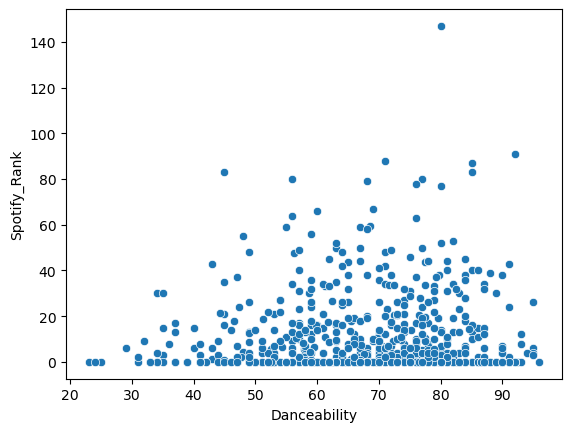

In [73]:
sns.scatterplot(x='Danceability', y='Spotify_Rank', data=music_df_result)

<Axes: xlabel='Valence', ylabel='Spotify_Rank'>

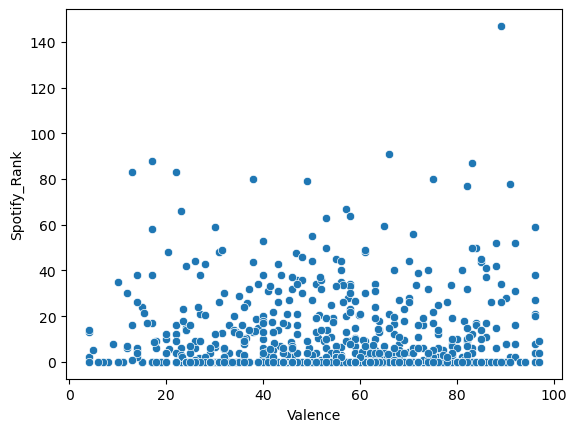

In [74]:
sns.scatterplot(x='Valence', y='Spotify_Rank', data=music_df_result)

<Axes: xlabel='Energy', ylabel='Spotify_Rank'>

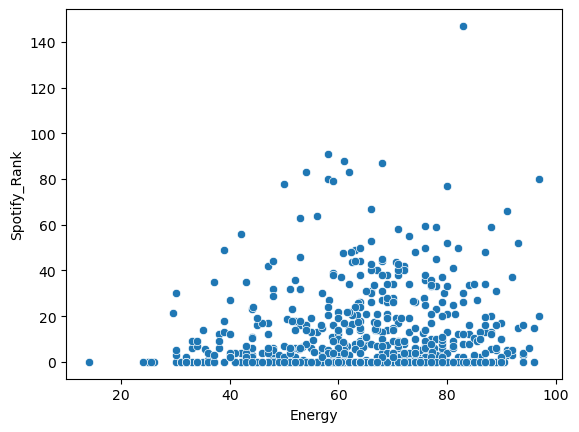

In [75]:
sns.scatterplot(x='Energy', y='Spotify_Rank', data=music_df_result)